# Install Library

In [34]:
# General
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.inspection import permutation_importance

# Modeling
import xgboost as xgb

# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split

# Tuning Model
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV


# Data Collection

## Read Data

In [3]:
# Read Data
data = pd.read_excel('dataset.xlsx')

## Data Target 

In [4]:
#Data Target
precip = data['Precip 24Hr (mm) 27']

#Function precip_class
def precip_class(precip):
    if precip == 0:
        return 'Tidak hujan'
    elif precip < 1:
        return 'Hujan sangat ringan'
    elif 1 <= precip < 5:
        return 'Hujan ringan'
    elif 5 <= precip < 10:
        return 'Hujan normal'
    elif 10 <= precip < 20:
        return 'Hujan lebat'
    else:
        return 'Hujan sangat lebat'
    
# Append precip_class to dataframe
data['Rain Class'] = precip.apply(precip_class)

## Drop Data

In [5]:
#Drop Data
data = data.drop(['Date and Time'] , axis=1)

In [6]:
data


,Air Tmp (C) M,Dew Pt (C) 27,RH (%) 27,Mag WD 2 Min (deg) 27,Precip 24Hr (mm) 27,precip class,QFE (hPa) 27,Visibility 1 Min (m) 27,WS (kt) 27,Rain Class
0,17.22,17.02,100.0,48.0,0.0,Tidak Hujan,859.42,18693.0,5.0,Tidak hujan
1,17.22,17.13,100.0,16.0,0.0,Tidak Hujan,859.70,20117.0,3.0,Tidak hujan
2,19.22,18.19,97.6,22.0,0.0,Tidak Hujan,860.12,42484.0,9.0,Tidak hujan
3,20.78,17.34,85.2,18.0,0.0,Tidak Hujan,860.20,47283.0,7.0,Tidak hujan
4,20.61,16.94,81.4,13.0,0.0,Tidak Hujan,859.62,75677.0,8.0,Tidak hujan
...,...,...,...,...,...,...,...,...,...,...
9478,16.44,16.76,100.0,281.0,0.0,Tidak Hujan,858.32,3929.0,2.0,Tidak hujan
9479,16.39,16.62,100.0,329.0,0.0,Tidak Hujan,858.67,112.0,1.0,Tidak hujan
9480,16.56,16.90,100.0,15.0,0.0,Tidak Hujan,859.18,1887.0,2.0,Tidak hujan
9481,19.78,19.17,95.7,35.0,0.0,Tidak Hujan,860.01,13293.0,1.0,Tidak hujan



## Re-order Columns

In [7]:
data = data[['Air Tmp (C) M', 'Dew Pt (C) 27', 'RH (%) 27', 'Mag WD 2 Min (deg) 27', 'QFE (hPa) 27', 'Visibility 1 Min (m) 27', 'WS (kt) 27', 'Precip 24Hr (mm) 27', 'Rain Class']]

## Rename Column

In [8]:
data.rename(columns={'Air Tmp (C) M': 'Air Tmp (C)',
                     'Dew Pt (C) 27': 'Dew Pt (C)',
                     'RH (%) 27': 'RH (%)',
                     'Mag WD 2 Min (deg) 27': 'Mag WD 2 Min (deg)',
                     'QFE (hPa) 27': 'QFE (hPa)',
                     'Visibility 1 Min (m) 27': 'Visibility 1 Min (m)',
                     'WS (kt) 27': 'WS (kt)', 
                     'Precip 24Hr (mm) 27': 'Precip 1Hr (mm)'
                     }, inplace=True)

C:\Users\Roviani Amelia\AppData\Local\Temp\ipykernel_23076\3474250135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Air Tmp (C) M': 'Air Tmp (C)',


# Data Understanding

## Description Data

In [9]:
data

,Air Tmp (C),Dew Pt (C),RH (%),Mag WD 2 Min (deg),QFE (hPa),Visibility 1 Min (m),WS (kt),Precip 1Hr (mm),Rain Class
0,17.22,17.02,100.0,48.0,859.42,18693.0,5.0,0.0,Tidak hujan
1,17.22,17.13,100.0,16.0,859.70,20117.0,3.0,0.0,Tidak hujan
2,19.22,18.19,97.6,22.0,860.12,42484.0,9.0,0.0,Tidak hujan
3,20.78,17.34,85.2,18.0,860.20,47283.0,7.0,0.0,Tidak hujan
4,20.61,16.94,81.4,13.0,859.62,75677.0,8.0,0.0,Tidak hujan
...,...,...,...,...,...,...,...,...,...
9478,16.44,16.76,100.0,281.0,858.32,3929.0,2.0,0.0,Tidak hujan
9479,16.39,16.62,100.0,329.0,858.67,112.0,1.0,0.0,Tidak hujan
9480,16.56,16.90,100.0,15.0,859.18,1887.0,2.0,0.0,Tidak hujan
9481,19.78,19.17,95.7,35.0,860.01,13293.0,1.0,0.0,Tidak hujan


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9483 entries, 0 to 9482
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Tmp (C)           8808 non-null   float64
 1   Dew Pt (C)            9188 non-null   float64
 2   RH (%)                9191 non-null   float64
 3   Mag WD 2 Min (deg)    9153 non-null   float64
 4   QFE (hPa)             9203 non-null   float64
 5   Visibility 1 Min (m)  9219 non-null   float64
 6   WS (kt)               9190 non-null   float64
 7   Precip 1Hr (mm)       9483 non-null   float64
 8   Rain Class            9483 non-null   object 
dtypes: float64(8), object(1)
memory usage: 666.9+ KB


In [11]:
data.describe()

,Air Tmp (C),Dew Pt (C),RH (%),Mag WD 2 Min (deg),QFE (hPa),Visibility 1 Min (m),WS (kt),Precip 1Hr (mm)
count,8808.000000,9188.000000,9191.000000,9153.000000,9203.000000,9219.000000,9190.000000,9483.000000
mean,18.905979,17.643133,91.624774,185.810991,859.354289,28294.566113,4.857780,0.241126
std,2.588492,1.445436,11.374133,103.935107,1.575119,20235.642479,3.012599,1.633888
min,12.110000,8.160000,34.500000,1.000000,853.390000,44.000000,0.000000,0.000000
25%,16.940000,16.810000,85.300000,93.000000,858.290000,10520.000000,3.000000,0.000000
50%,18.110000,17.680000,98.000000,212.000000,859.390000,25617.000000,4.000000,0.000000
75%,20.670000,18.600000,100.000000,252.000000,860.460000,42748.000000,6.000000,0.000000
max,27.170000,21.940000,100.000000,360.000000,864.940000,80467.000000,22.000000,37.700000


In [12]:
data.shape

(9483, 9)

In [13]:
data.groupby("Rain Class").size()

Rain Class
Hujan lebat              37
Hujan normal             59
Hujan ringan            279
Hujan sangat lebat       21
Hujan sangat ringan     873
Tidak hujan            8214
dtype: int64

## Visualize Data

### Categorical Data

#### Distribusi Hujan

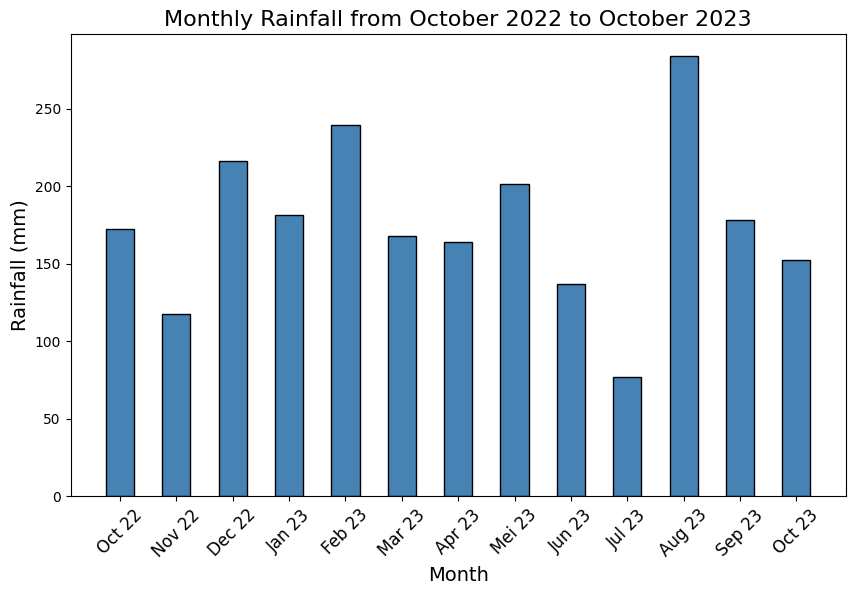

In [14]:
#Distribution of Monthly Rainfall 
curah_hujan = [172.1, 117.3, 216.1, 181.4, 239.2, 168, 163.7, 201.2, 136.7, 76.8, 283.7, 178.1, 152.3]
bulan = ['Oct 22', 'Nov 22', 'Dec 22', 'Jan 23', 'Feb 23', 'Mar 23', 'Apr 23', 'Mei 23', 'Jun 23', 'Jul 23', 'Aug 23', 'Sep 23', 'Oct 23']
plt.figure(figsize=(10, 6))
plt.bar(bulan, curah_hujan, width=0.5, color='#4682B4', edgecolor='black')
plt.title('Monthly Rainfall from October 2022 to October 2023', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Rainfall (mm)', fontsize=14)
plt.xticks(ticks=range(13), rotation=45, fontsize=12)
plt.show()

#### Distribusi Hujan Per Bulan

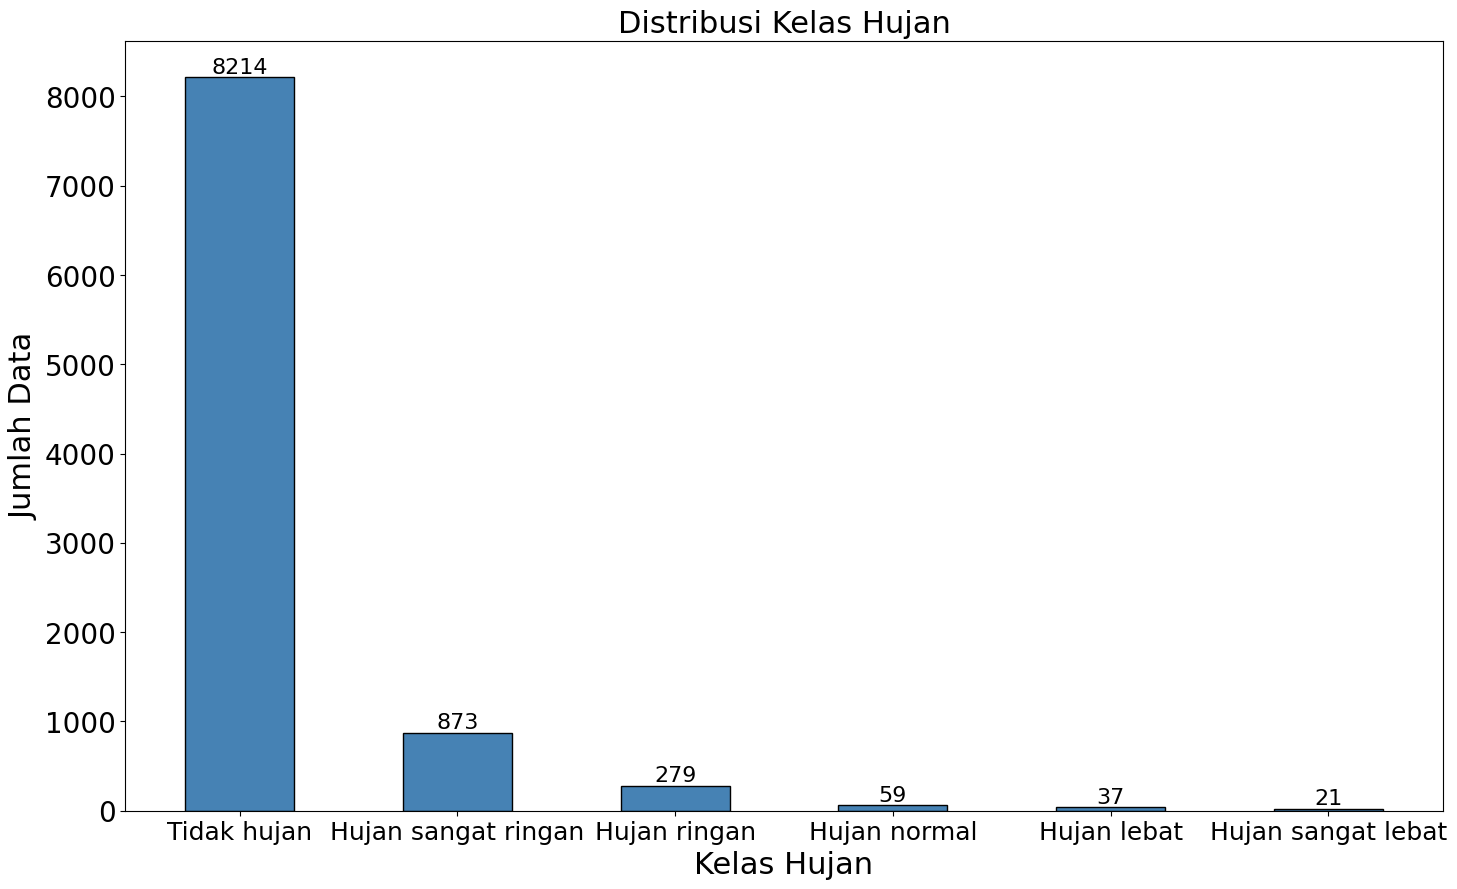

In [15]:
#Distribution of Variable Target
rain_class = data['Rain Class'].value_counts()

plt.figure(figsize=(17, 10))
bars = plt.bar(rain_class.index, rain_class.values, width=0.5, color='#4682B4', edgecolor='black')
for bar, value in zip(bars, rain_class.values):
    plt.text(bar.get_x() + bar.get_width() / 2, value, str(value), ha='center', va='bottom', fontsize=16)
plt.title('Distribusi Kelas Hujan', fontsize=22)
plt.xlabel('Kelas Hujan', fontsize=22)
plt.ylabel('Jumlah Data', fontsize=22)
plt.xticks(fontsize=18, rotation=0)  
plt.yticks(fontsize=20)
plt.show()

### Numerical_data

In [16]:
numerical_data = data.select_dtypes(include=['int64', 'float64']).columns

#### Histogram

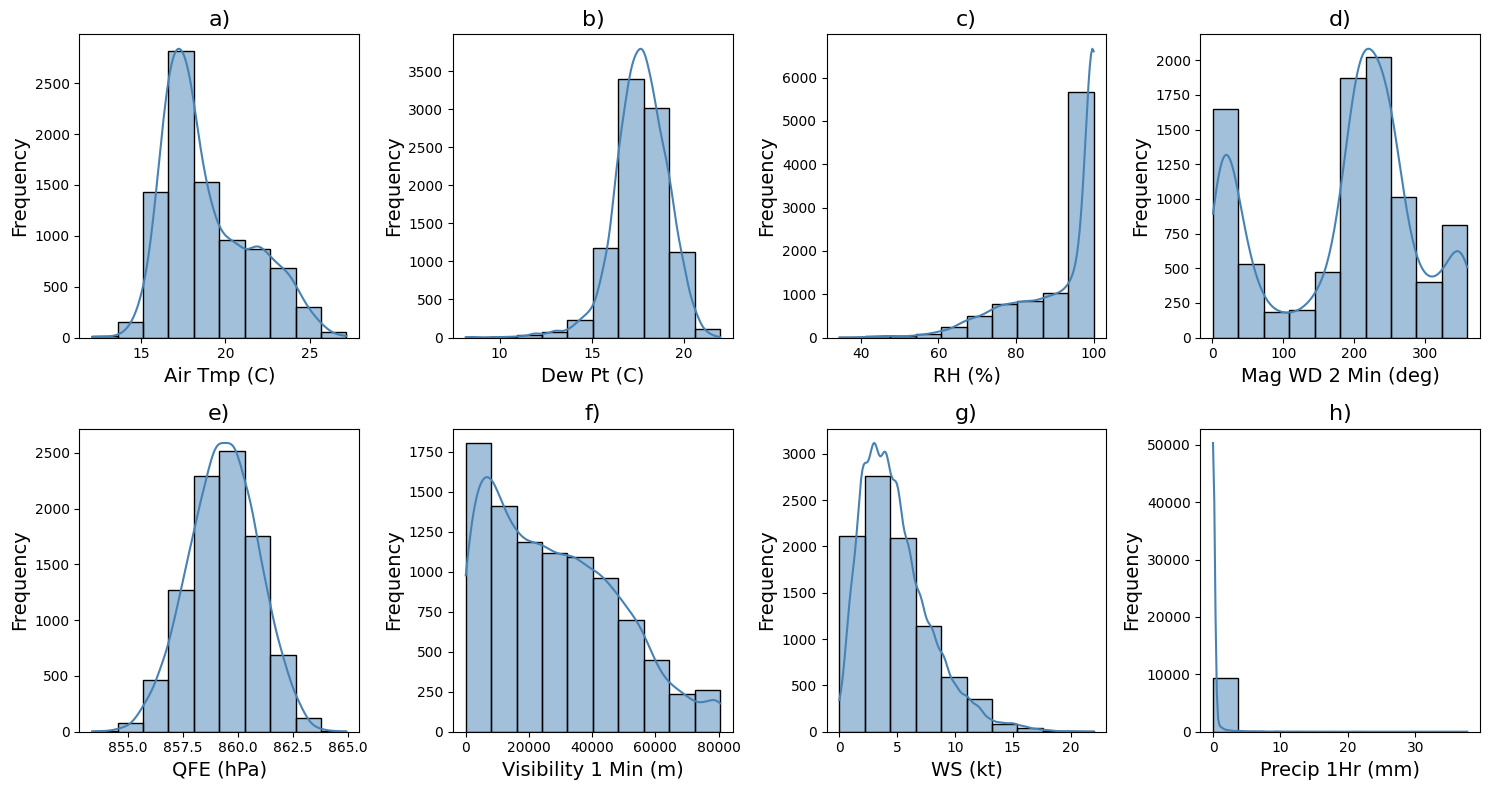

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anggap data dan numerical_data sudah didefinisikan sebelumnya

# Membuat subplot dengan 2 baris dan 4 kolom
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

# List huruf untuk judul grafik
titles = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

# Menggunakan loop untuk membuat histogram untuk setiap kolom
for i, column in enumerate(numerical_data):
    row = i // 4  # Baris ke berapa
    col = i % 4   # Kolom ke berapa
    ax = axes[row, col]  # Mengambil sumbu yang sesuai

    # Membuat histogram plot dengan KDE
    sns.histplot(data=data, x=column, kde=True, ax=ax, bins=10, color='#4682B4', edgecolor='black')
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    # Menambahkan judul
    ax.set_title(f'{titles[i]})', fontsize=16)

# Menyembunyikan subplot yang tidak terpakai jika data tidak mencapai 8 kolom
if len(numerical_data) < 8:
    for j in range(len(numerical_data), 8):
        row = j // 4
        col = j % 4
        fig.delaxes(axes[row, col])

# Menyusun subplot dan menampilkan plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()


#### Box Plot

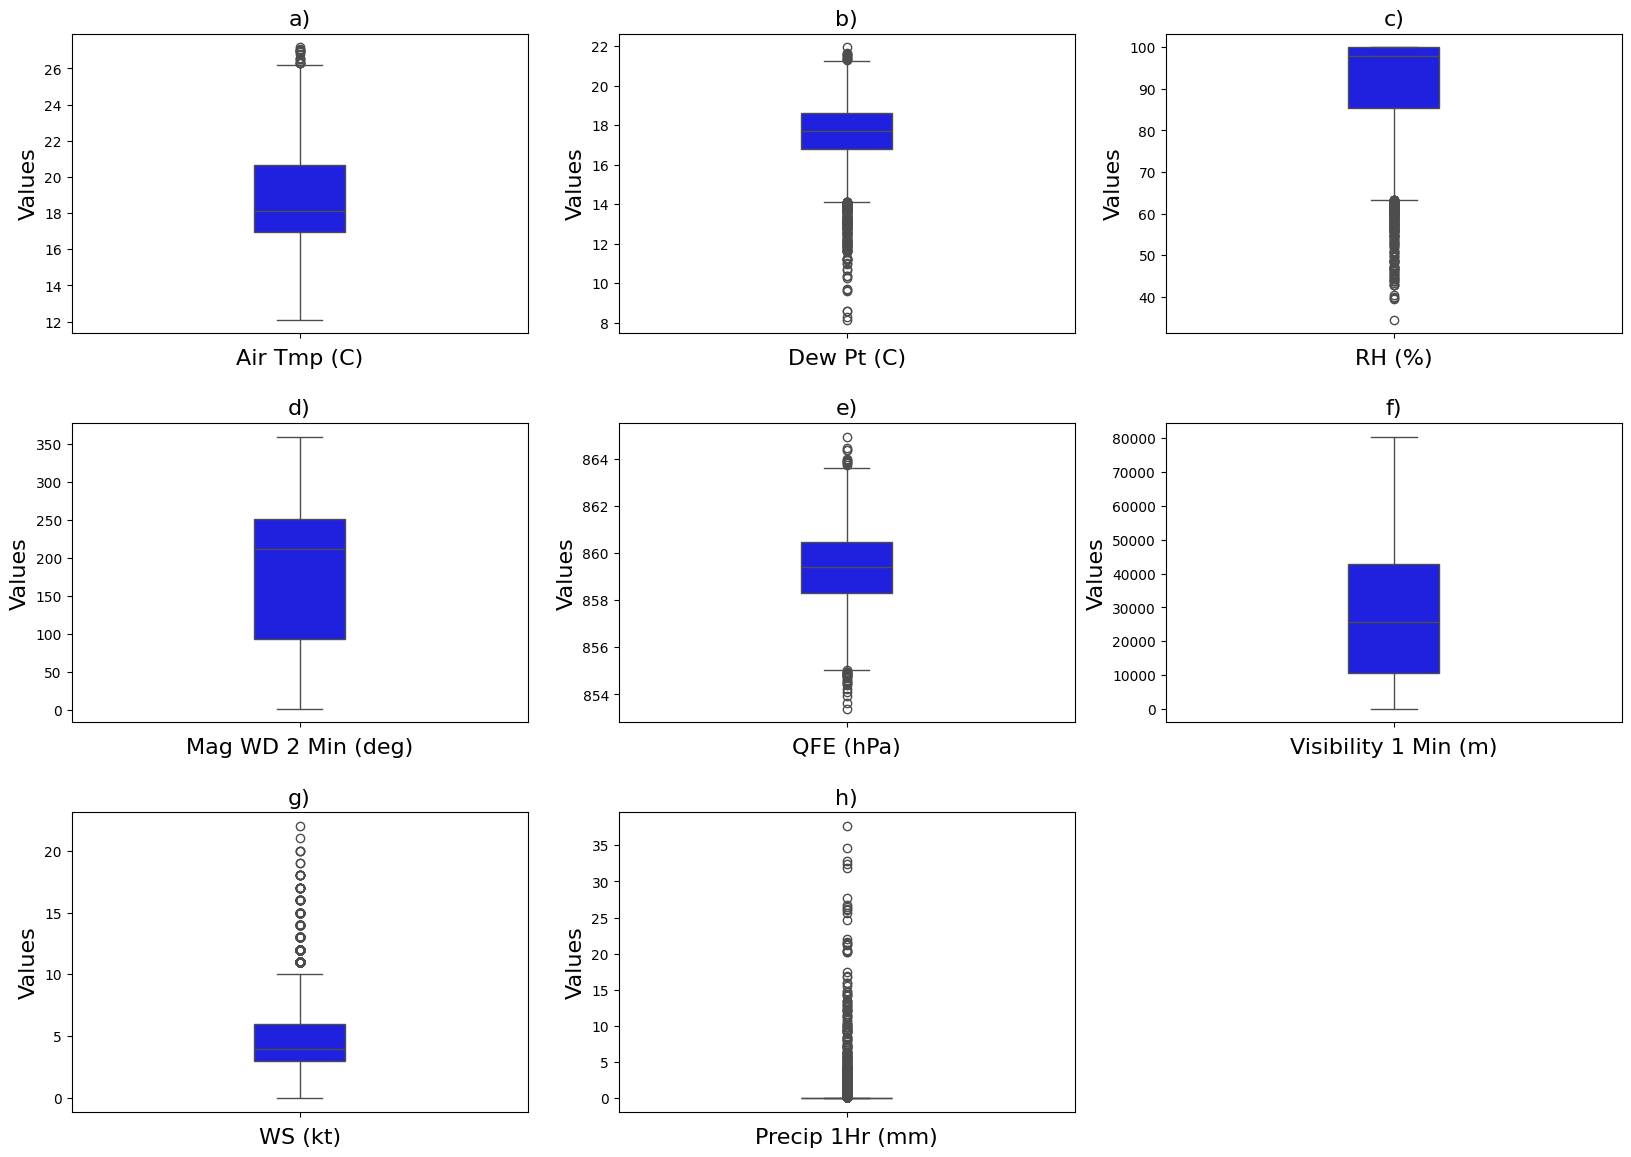

In [18]:
# Menentukan ukuran figure
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 14))
ax = ax.flatten()  # Mengubah array 2D dari axes menjadi 1D untuk memudahkan indexing

# List huruf untuk judul grafik
titles = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

# Looping melalui setiap feature dan subplot axes
for i, ft in enumerate(numerical_data):
    sns.boxplot(data=data, y=ft, ax=ax[i], color='blue', width=0.2)
    ax[i].set_title(f'{titles[i]})', fontsize=16)
    ax[i].set_xlabel(ft, fontsize=16)
    ax[i].set_ylabel('Values', fontsize=16)
    

# Menyembunyikan axes yang tidak digunakan jika jumlah features kurang dari jumlah subplot
for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)

plt.subplots_adjust(hspace=0.3)  # Memberikan jarak vertikal antar subplot
plt.yticks(fontsize=14)
plt.show()

# Data Pre-processing

## Missing value

In [19]:
data.isnull().sum()

Air Tmp (C)             675
Dew Pt (C)              295
RH (%)                  292
Mag WD 2 Min (deg)      330
QFE (hPa)               280
Visibility 1 Min (m)    264
WS (kt)                 293
Precip 1Hr (mm)           0
Rain Class                0
dtype: int64

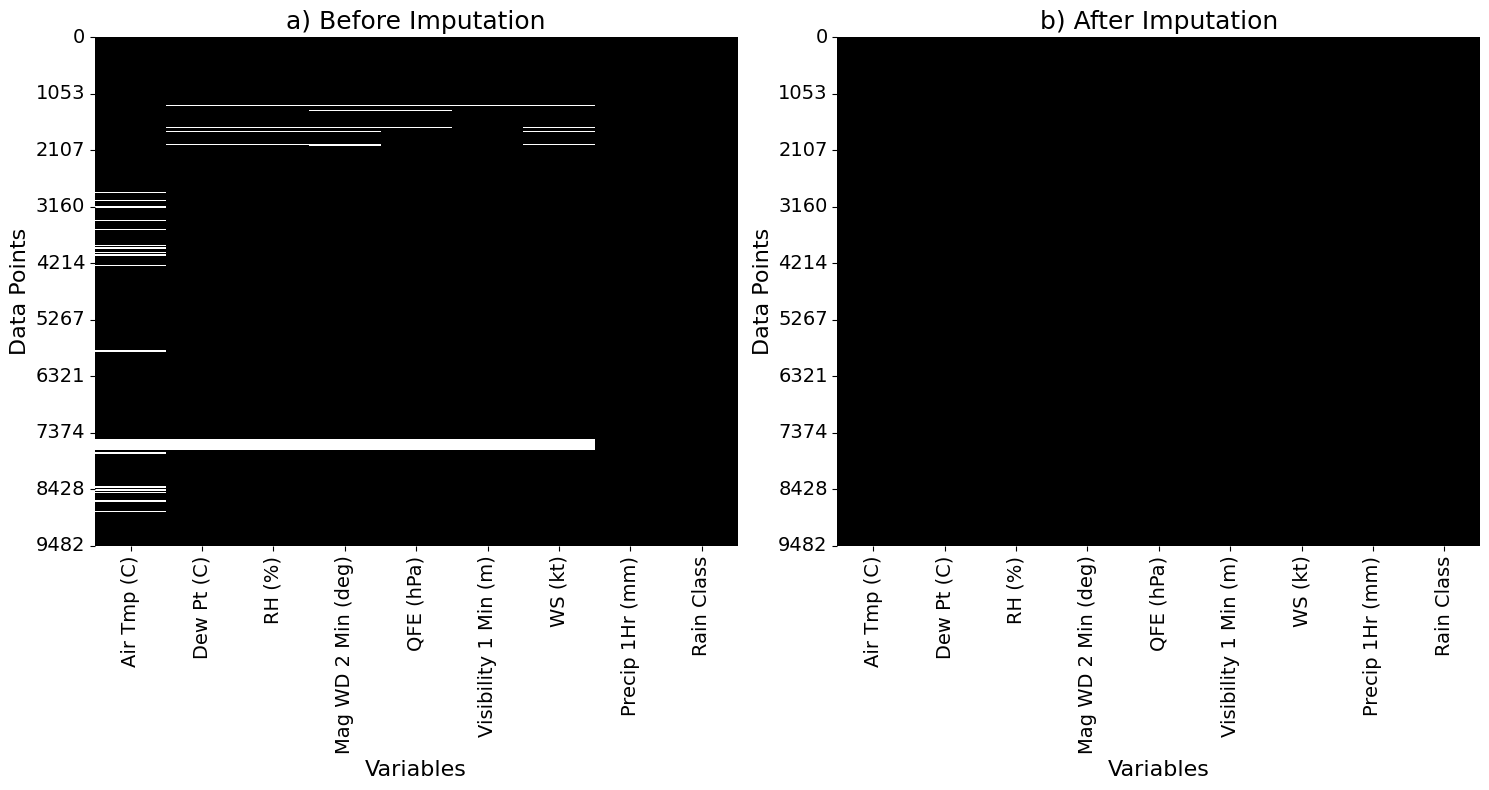

In [20]:
# Mengubah ukuran figur
plt.figure(figsize=(15, 8))

# Memvisualisasikan missing value sebelum imputasi
plt.subplot(1, 2, 1)
sns.heatmap(data.isnull(), cbar=False, cmap='bone')
plt.title('a) Before Imputation', fontsize=18)
plt.xlabel('Variables', fontsize=16)
plt.ylabel('Data Points', fontsize=16)
plt.yticks(np.linspace(0, len(data) - 1, 10), np.linspace(0, len(data) - 1, 10).astype(int), fontsize=14)
plt.xticks(fontsize=14)
data_imputed = data.interpolate(method='linear')

# Memvisualisasikan missing value setelah imputasi
plt.subplot(1, 2, 2)
sns.heatmap(data_imputed.isnull(), cbar=False, cmap='bone')
plt.title('b) After Imputation', fontsize=18)
plt.xlabel('Variables', fontsize=16)
plt.ylabel('Data Points', fontsize=16)
plt.yticks(np.linspace(0, len(data_imputed) - 1, 10), np.linspace(0, len(data_imputed) - 1, 10).astype(int), fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()


In [21]:
data=data_imputed

In [22]:
data.isnull().sum()

Air Tmp (C)             0
Dew Pt (C)              0
RH (%)                  0
Mag WD 2 Min (deg)      0
QFE (hPa)               0
Visibility 1 Min (m)    0
WS (kt)                 0
Precip 1Hr (mm)         0
Rain Class              0
dtype: int64

## Encoding

In [23]:
# Membuat dictionary untuk mapping kategori ke nilai numerik
kategori_mapping = {
    "Tidak hujan": 0,
    "Hujan sangat ringan": 1,
    "Hujan ringan": 2,
    "Hujan normal": 3,
    "Hujan lebat": 4,
    "Hujan sangat lebat": 5
}

data['Rain Class'] = data['Rain Class'].map(kategori_mapping)

In [24]:
data

,Air Tmp (C),Dew Pt (C),RH (%),Mag WD 2 Min (deg),QFE (hPa),Visibility 1 Min (m),WS (kt),Precip 1Hr (mm),Rain Class
0,17.22,17.02,100.0,48.0,859.42,18693.0,5.0,0.0,0
1,17.22,17.13,100.0,16.0,859.70,20117.0,3.0,0.0,0
2,19.22,18.19,97.6,22.0,860.12,42484.0,9.0,0.0,0
3,20.78,17.34,85.2,18.0,860.20,47283.0,7.0,0.0,0
4,20.61,16.94,81.4,13.0,859.62,75677.0,8.0,0.0,0
...,...,...,...,...,...,...,...,...,...
9478,16.44,16.76,100.0,281.0,858.32,3929.0,2.0,0.0,0
9479,16.39,16.62,100.0,329.0,858.67,112.0,1.0,0.0,0
9480,16.56,16.90,100.0,15.0,859.18,1887.0,2.0,0.0,0
9481,19.78,19.17,95.7,35.0,860.01,13293.0,1.0,0.0,0


## Correlation Matrix

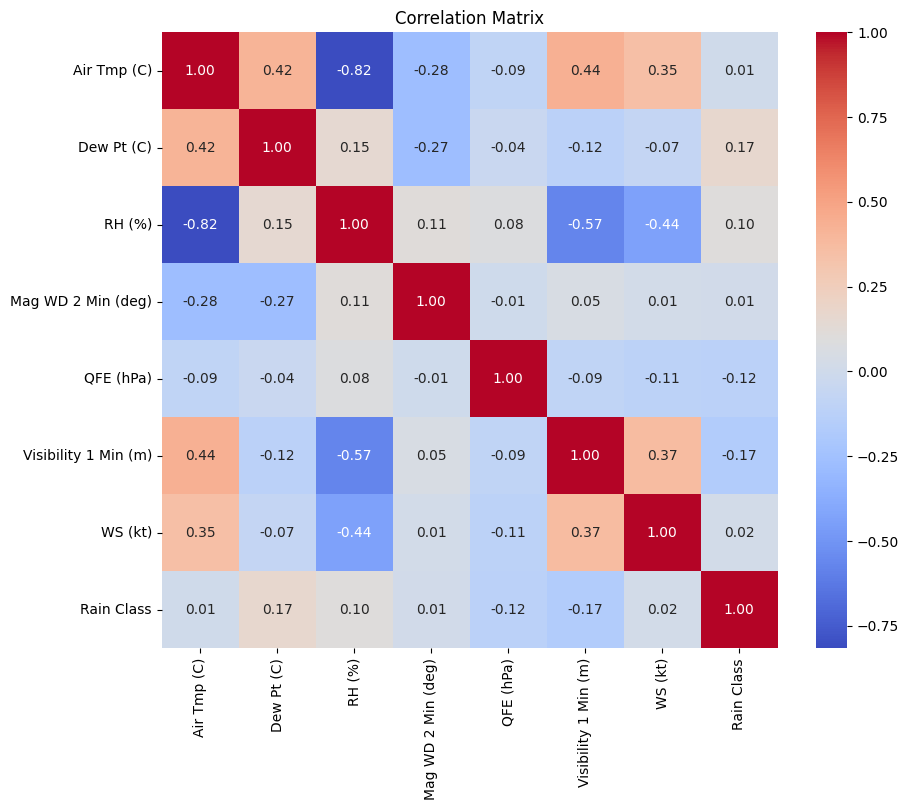

In [25]:
data = data.drop('Precip 1Hr (mm)', axis=1)

# Menghitung matriks korelasi
corr_matrix = data.corr()

# Membuat heatmap dari matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

## Feature Importance

In [38]:
# Read Data
df = pd.read_excel('cleaned_data.xlsx')

# Memisahkan fitur dan label
X_tes = df.drop(['Rain Class'], axis=1)
y_tes = df['Rain Class']

# Menerapkan SMOTE
sm = SMOTE(random_state=42, k_neighbors=min(2, len(y_tes.unique()) - 1))
X_s, y_s = sm.fit_resample(X_tes, y_tes)

# Split Data
X_tr, X_ts, y_tr, y_ts = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

# Mendefinisikan hyperparameter model
hyperparameters = {
    'max_depth': 6,
    'min_child_weight': 1,
    'learning_rate': 0.3,
    'n_estimators': 100,
    'subsample': 1,
    'colsample_bytree': 1,
}

# Mendefinisikan model XGBoost dengan hyperparameter
modell = xgb.XGBClassifier(**hyperparameters, use_label_encoder=False)

# Melatih model
modell.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

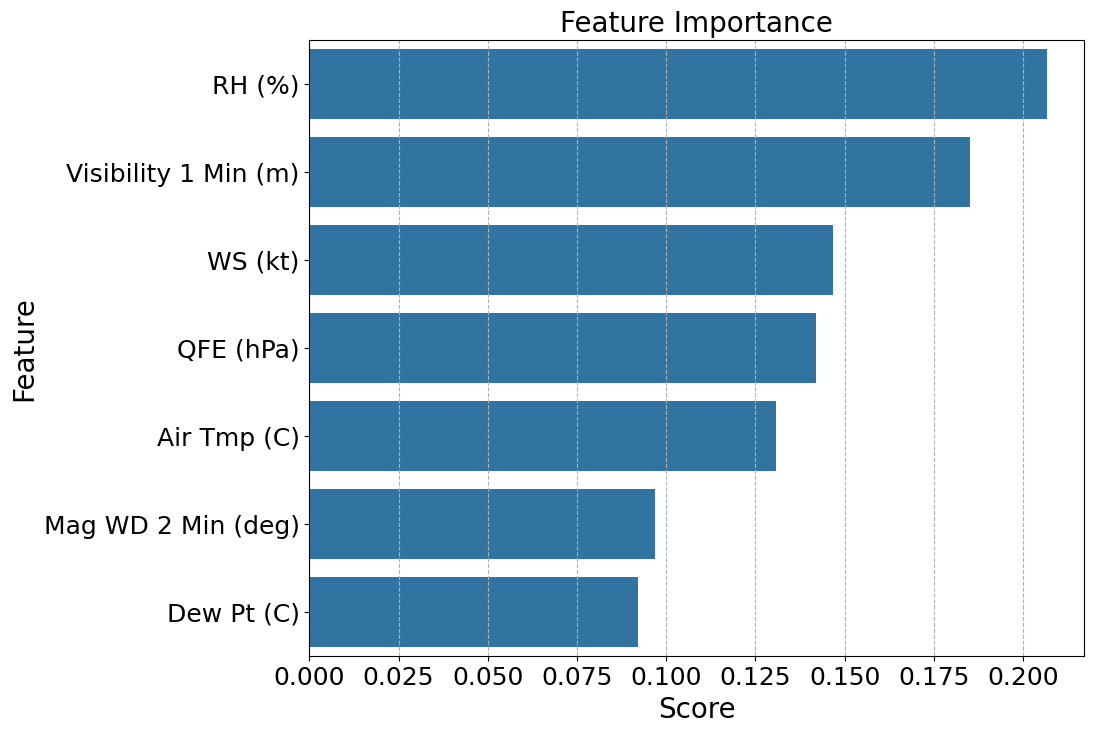

In [39]:
# Mendapatkan feature importance
feature_importance = modell.feature_importances_

# Mendapatkan nama fitur, asumsikan X_train adalah pandas DataFrame
feature_names = X_tr.columns

# Membuat DataFrame dari feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Mengurutkan DataFrame berdasarkan importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Membuat plot
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Score', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 
plt.grid(axis='x', linestyle='--')
plt.show()

## Permutation Importance

<Figure size 1500x800 with 0 Axes>

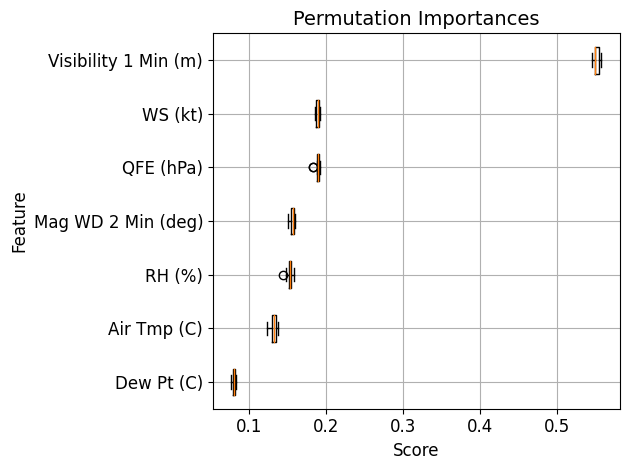

In [41]:
feature_names = X_s.columns.tolist() 

# Menghitung permutation importance
results = permutation_importance(modell, X_ts, y_ts, n_repeats=10, random_state=42, n_jobs=-1)

# Hasil importance
importance = results.importances_mean

# Nama fitur dari dataset Anda
feature_names = X_s.columns.tolist()  # Misalkan X adalah DataFrame pandas

# Visualisasi
plt.figure(figsize=(15, 8))
fig, ax = plt.subplots()
sorted_idx = np.argsort(importance)
ax.boxplot(results.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
ax.set_title("Permutation Importances", fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
fig.tight_layout()
plt.grid()
plt.show()

## Imbalance data

In [42]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
data = data.drop(['Dew Pt (C)', 'Mag WD 2 Min (deg)'] , axis=1)

# Memisahkan fitur dan label
X = data.drop(['Rain Class'], axis=1)
y = data['Rain Class']

# Strategi undersampling
undersample_strategy = {
    0: 279,
    1: 279
}

# Inisialisasi Cluster Centroid
cluster_centroids = ClusterCentroids(sampling_strategy=undersample_strategy, random_state=42)

# Terapkan Cluster Centroid pada data
X_under, y_under = cluster_centroids.fit_resample(X, y)

# Strategi oversampling
oversample_strategy = {
    2: 279, 
    3: 279,  
    4: 279,  
    5: 279   
}

# Inisialisasi SMOTE
smote = SMOTE(sampling_strategy=oversample_strategy, random_state=42)

X_sm, y_sm = smote.fit_resample(X_under, y_under)


c:\Users\Roviani Amelia\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Roviani Amelia\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


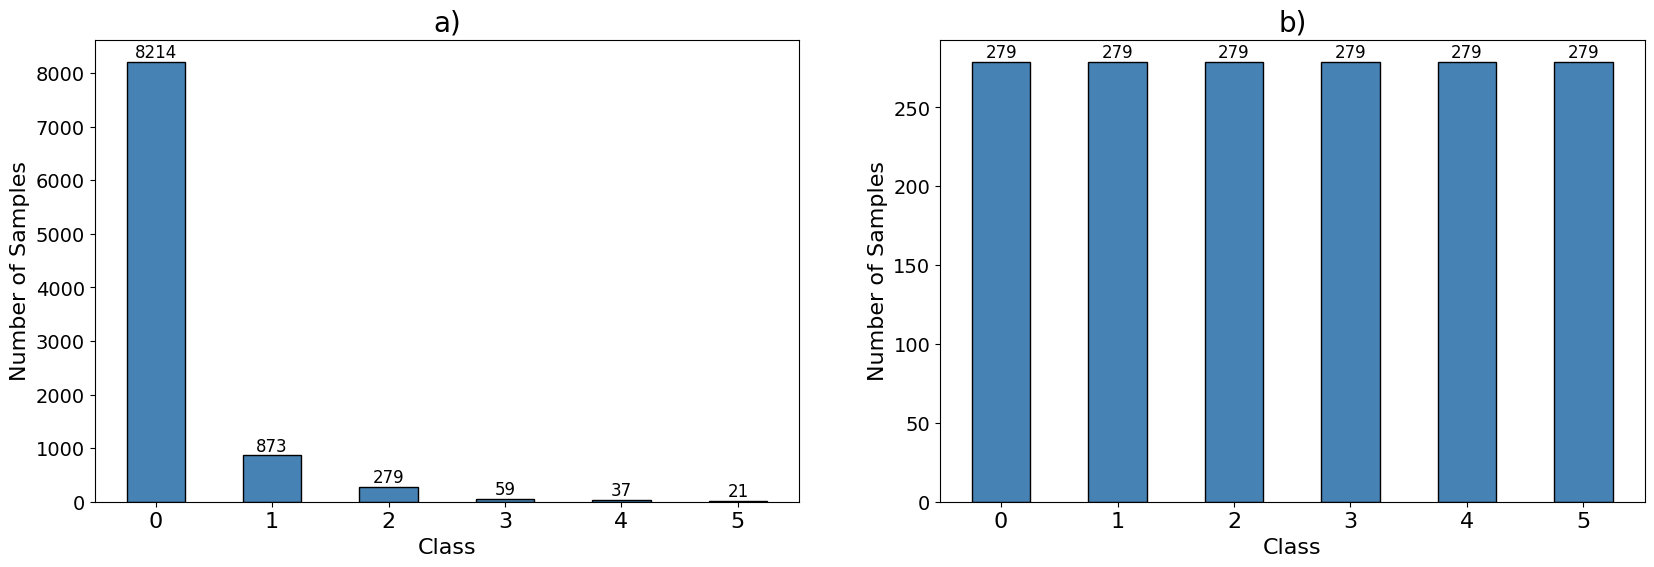

In [44]:
def plot_class_distribution(y, title, ax):
    class_counts = y.value_counts().sort_index()
    
    # Membuat bar plot pada axes yang diberikan
    bars = ax.bar(class_counts.index, class_counts.values, width=0.5, color='#4682B4', edgecolor='black')
    
    # Menambahkan nilai teks di atas setiap bar
    for bar, value in zip(bars, class_counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, value, str(value), 
                ha='center', va='bottom', fontsize=12, color='black')
    
    ax.set_xlabel('Class', fontsize=16)
    ax.set_ylabel('Number of Samples', fontsize=16)
    ax.set_title(title, fontsize=20)
    ax.set_xticks(class_counts.index)
    ax.set_xticklabels(class_counts.index, fontsize=16, rotation=0)
    ax.tick_params(axis='y', labelsize=14)

# Membuat figure dan axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Visualisasi distribusi kelas sebelum SMOTE
plot_class_distribution(y, 'a)', axes[0])

# Visualisasi distribusi kelas setelah SMOTE
plot_class_distribution(y_sm, 'b)', axes[1])

plt.subplots_adjust(wspace=0.2)
plt.show()

c:\Users\Roviani Amelia\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Roviani Amelia\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Roviani Amelia\AppData\Local\Temp\ipykernel_23076\3227630408.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(np.unique(y)))


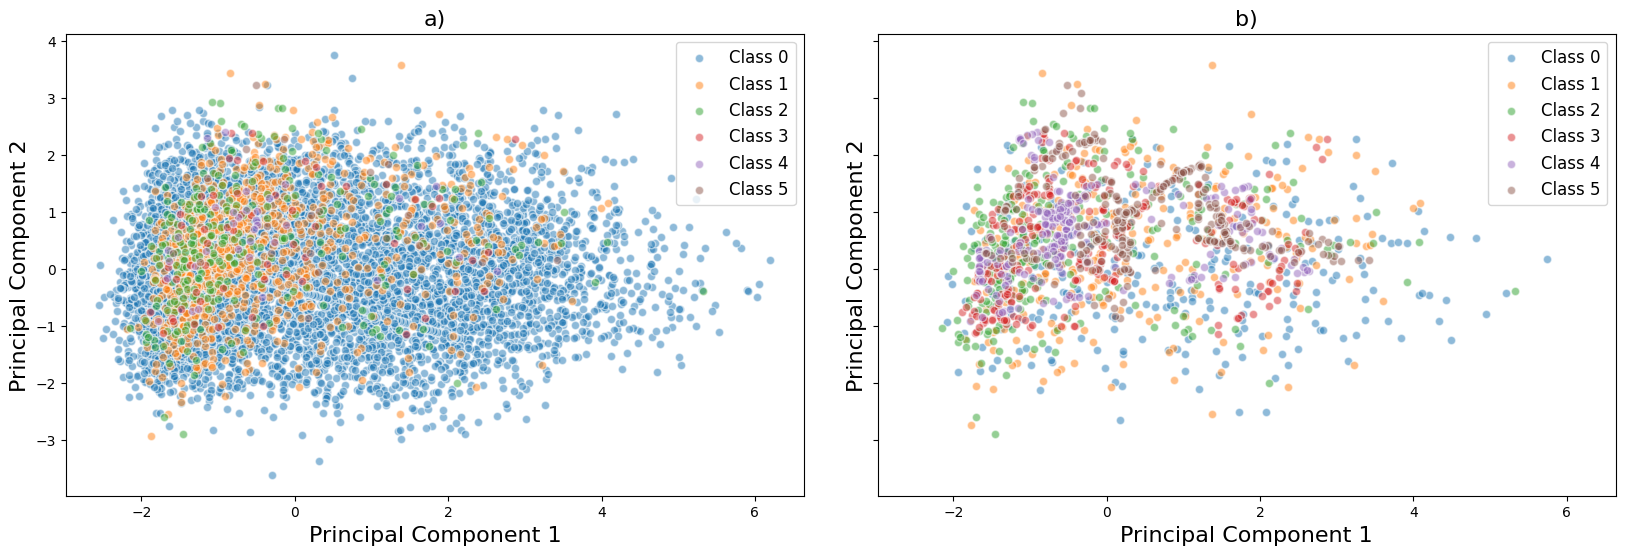

In [45]:
# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA dengan pengaturan random_state untuk konsistensi
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Strategi undersampling
undersample_strategy = {
    0: 279,
    1: 279
}

# Inisialisasi Cluster Centroid
cluster_centroids = ClusterCentroids(sampling_strategy=undersample_strategy, random_state=42)

# Terapkan Cluster Centroid pada data
X_under, y_under = cluster_centroids.fit_resample(X_scaled, y)

# Strategi oversampling
oversample_strategy = {
    2: 279, 
    3: 279,  
    4: 279,  
    5: 279   
}

# Inisialisasi SMOTE
smote = SMOTE(sampling_strategy=oversample_strategy, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_under, y_under)
X_resampled_pca = pca.transform(X_resampled)

# Visualisasi
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), sharex=True, sharey=True)
colors = plt.cm.get_cmap('tab10', len(np.unique(y)))

# Plot untuk data sebelum Diseimbangkan
for class_value in np.unique(y):
    mask = y == class_value
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], alpha=0.5, label=f"Class {class_value}", 
                    edgecolors='w')
axes[0].set_title('a)', fontsize=16)
axes[0].set_xlabel('Principal Component 1', fontsize=16)
axes[0].set_ylabel('Principal Component 2', fontsize=16)
axes[0].legend(fontsize=12)

# Plot untuk data setelah Diseimbangkan
for class_value in np.unique(y_resampled):
    mask = y_resampled == class_value
    axes[1].scatter(X_resampled_pca[mask, 0], X_resampled_pca[mask, 1], alpha=0.5, label=f"Class {class_value}", 
                    edgecolors='w')
axes[1].set_title('b)', fontsize=16)
axes[1].set_xlabel('Principal Component 1', fontsize=16)
axes[1].set_ylabel('Principal Component 2', fontsize=16)
axes[1].legend(fontsize=12)

plt.subplots_adjust(wspace=0.1)
plt.show()


# Modeling

In [45]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## XGBoost Model

In [47]:
# Mendefinisikan hyperparameter model
hyperparameters = {
    'max_depth': 6,
    'min_child_weight': 1,
    'learning_rate': 0.3,
    'n_estimators': 100,
    'subsample': 1,
    'colsample_bytree': 1,
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Mendefinisikan model XGBoost dengan hyperparameter
model = xgb.XGBClassifier(**hyperparameters, use_label_encoder=False)

accuracies = []
all_y_test = []
all_y_pred = []

# Loop melalui setiap fold
for train_index, test_index in kf.split(X_sm, y_sm):
    # Split data
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Melatih model
    model.fit(X_train, y_train)
    
    # Melakukan prediksi pada data pengujian
    y_pred = model.predict(X_test)
    
    # Menghitung akurasi pada data pengujian
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Akurasi pada fold: {accuracy}")

    # Menyimpan hasil prediksi dan data uji
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Rata-rata dan Standar Deviasi
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Rata-rata akurasi pada 5-fold cross-validation: {mean_accuracy}")
print(f"Standar Deviasi akurasi pada 5-fold cross-validation: {std_accuracy}")

Akurasi pada fold: 0.746268656716418
Akurasi pada fold: 0.7402985074626866
Akurasi pada fold: 0.7164179104477612
Akurasi pada fold: 0.7701492537313432
Akurasi pada fold: 0.7694610778443114
Rata-rata akurasi pada 5-fold cross-validation: 0.748519081240504
Standar Deviasi akurasi pada 5-fold cross-validation: 0.02004773799598016


## Classification report

In [48]:
# Menampilkan classification report
report = classification_report(all_y_test, all_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       279
           1       0.60      0.53      0.56       279
           2       0.65      0.59      0.62       279
           3       0.72      0.73      0.73       279
           4       0.79      0.84      0.82       279
           5       0.85      0.91      0.88       279

    accuracy                           0.75      1674
   macro avg       0.74      0.75      0.74      1674
weighted avg       0.74      0.75      0.74      1674



## Confusion Matrix

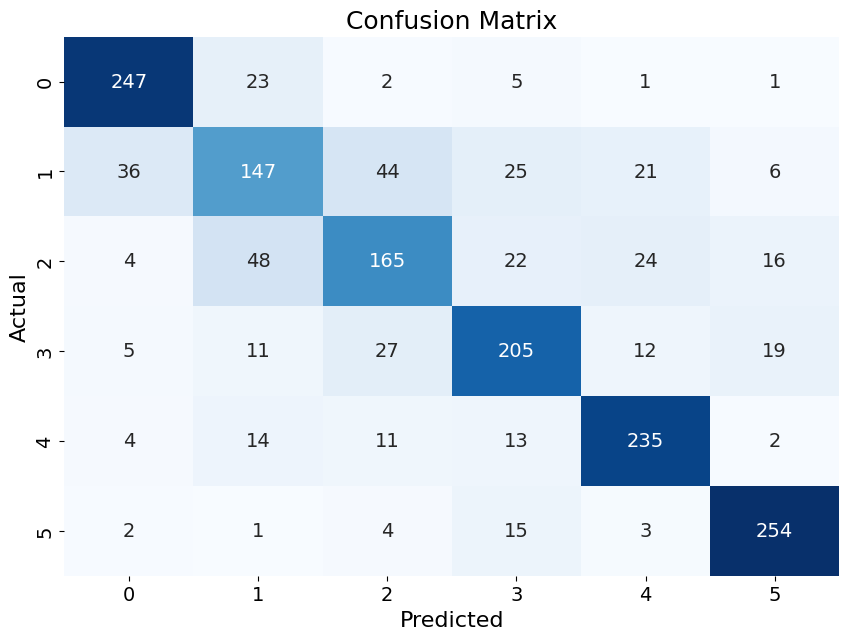

In [49]:
# Menghitung confusion matrix dari semua prediksi
conf_matrix = confusion_matrix(all_y_test, all_y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"fontsize": 14},
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.show()

## Loss Curve

c:\Users\Roviani Amelia\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


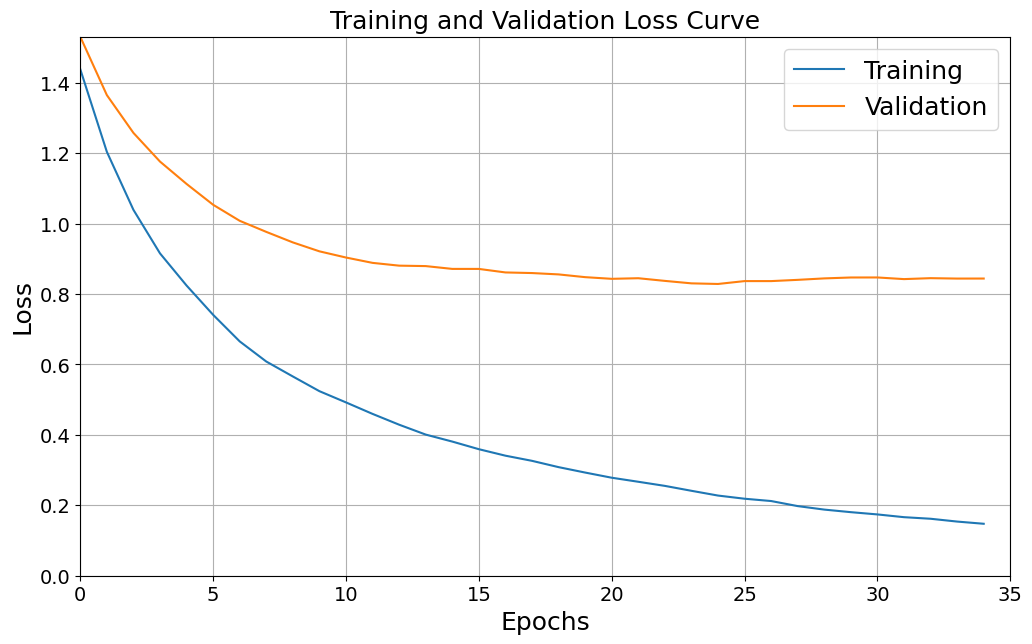

Akurasi pada data pengujian:  0.7559523809523809


In [50]:
# Membagi dataset menjadi training set, validation set, dan testing set
X_train, X_temp, y_train, y_temp = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Mendefinisikan hyperparameter model
hyperparameters = {
    'max_depth': 6,
    'min_child_weight': 1,
    'learning_rate': 0.3,
    'n_estimators': 100,
    'subsample': 1,
    'colsample_bytree': 1,
    'num_class': 6,  
    'eval_metric': 'mlogloss',
    'use_label_encoder': False
}

# Mendefinisikan model XGBoost dengan hyperparameter
model = xgb.XGBClassifier(**hyperparameters)

# Melatih model dengan data training dan validasi
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=False)

# Mengakses hasil evaluasi
results = model.evals_result()

# Membuat grafik dari loss training dan validasi
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Training')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend(fontsize=18) 
ax.set_xlabel('Epochs', fontsize=18) 
ax.set_ylabel('Loss', fontsize=18) 
plt.title('Training and Validation Loss Curve', fontsize=18) 
ax.tick_params(axis='x', labelsize=14)  
ax.tick_params(axis='y', labelsize=14)
plt.grid()

# Menetapkan batas sumbu y dari 0 sampai nilai maksimum loss di kedua kurva
max_loss = max(max(results['validation_0']['mlogloss']), max(results['validation_1']['mlogloss']))
ax.set_ylim([0, max_loss])
ax.set_xlim([0, epochs])
plt.show()

# Melakukan prediksi pada data pengujian
y_pred = model.predict(X_test)

# Menghitung akurasi pada data pengujian
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi pada data pengujian: ", accuracy)

# Hyperparameter Tuning 

## Random Search

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

# Parameter untuk Random Search
params = {
    'max_depth': list(range(1, 21)),  # Mulai dari 1, berakhir di 20
    'min_child_weight': list(range(1, 21)),  # Mulai dari 1, berakhir di 20
    'learning_rate': [i * 0.1 + 0.1 for i in range(0, 10)],  # Mulai dari 0.1, berakhir di 1.0
    'n_estimators': list(range(100, 511, 10)),  # Mulai dari 100, berakhir di 500
    'subsample': [i * 0.01 + 0.8 for i in range(21)],  # Mulai dari 0.8, berakhir di 1.0
    'colsample_bytree': [i * 0.01 + 0.5 for i in range(21)]  # Mulai dari 0.5, berakhir di 0.7
}

# Membuat model XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, 
                              eval_metric='logloss')

# Menerapkan RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=params, 
                                   n_iter=100, 
                                   scoring='accuracy', 
                                   cv=5, random_state=42)

# Melatih model dengan Random Search
random_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best parameters:", random_search.best_params_)

Best parameters: {'subsample': 0.9600000000000001, 'n_estimators': 380, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.69}


## Random Search Evaluation 

Akurasi pada fold: 0.7522388059701492
Akurasi pada fold: 0.7492537313432835
Akurasi pada fold: 0.7164179104477612
Akurasi pada fold: 0.7820895522388059
Akurasi pada fold: 0.7754491017964071


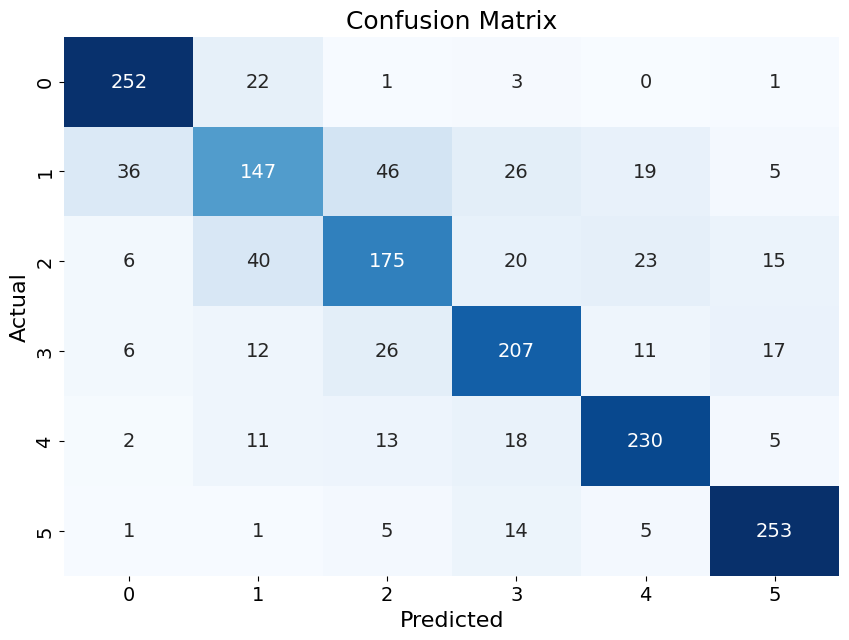

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       279
           1       0.63      0.53      0.57       279
           2       0.66      0.63      0.64       279
           3       0.72      0.74      0.73       279
           4       0.80      0.82      0.81       279
           5       0.85      0.91      0.88       279

    accuracy                           0.76      1674
   macro avg       0.75      0.76      0.75      1674
weighted avg       0.75      0.76      0.75      1674

Rata-rata akurasi pada 5-fold cross-validation: 0.7550898203592814
Standar Deviasi akurasi pada 5-fold cross-validation: 0.023156816259826105


In [66]:
# Mendefinisikan hyperparameter model
hyperparameters = {
    'max_depth': 8,
    'min_child_weight': 3,
    'learning_rate': 0.1,
    'n_estimators': 380,
    'subsample': 0.96,
    'colsample_bytree': 0.69,
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Mendefinisikan model XGBoost dengan hyperparameter
model = xgb.XGBClassifier(**hyperparameters, use_label_encoder=False)

accuracies = []
all_y_test = []
all_y_pred = []

# Loop melalui setiap fold
for train_index, test_index in kf.split(X_sm, y_sm):
    # Split data
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Melatih model
    model.fit(X_train, y_train)
    
    # Melakukan prediksi pada data pengujian
    y_pred = model.predict(X_test)
    
    # Menghitung akurasi pada data pengujian
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Akurasi pada fold: {accuracy}")

    # Menyimpan hasil prediksi dan data uji
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Menghitung confusion matrix dari semua prediksi
conf_matrix = confusion_matrix(all_y_test, all_y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"fontsize": 14},
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.show()

# Menampilkan classification report
report = classification_report(all_y_test, all_y_pred)
print(report)

# Rata-rata dan Standar Deviasi
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Rata-rata akurasi pada 5-fold cross-validation: {mean_accuracy}")
print(f"Standar Deviasi akurasi pada 5-fold cross-validation: {std_accuracy}")

## Bayesian Optimization

In [67]:
!pip install scikit-optimize


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
# Mendefinisikan model XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, 
                              eval_metric='logloss')

# Mendefinisikan ruang pencarian hyperparameter
search_space = {
    'max_depth': list(range(1, 21)),  # Mulai dari 1, berakhir di 20
    'min_child_weight': list(range(1, 21)),  # Mulai dari 1, berakhir di 20
    'learning_rate': [i * 0.1 + 0.1 for i in range(0, 10)],  # Mulai dari 0.1, berakhir di 1.0
    'n_estimators': list(range(100, 511, 10)),  # Mulai dari 100, berakhir di 500
    'subsample': [i * 0.01 + 0.8 for i in range(21)],  # Mulai dari 0.8, berakhir di 1.0
    'colsample_bytree': [i * 0.01 + 0.5 for i in range(21)]  # Mulai dari 0.5, berakhir di 0.7
}

bayes_search = BayesSearchCV(
    xgb_model, 
    search_space, 
    n_iter=100, 
    scoring='accuracy',
    cv=5, random_state=42)

# Melatih model dengan Bayesian Optimization
bayes_search.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
print("Best hyperparameters found: ", bayes_search.best_params_)


Best hyperparameters found:  OrderedDict([('colsample_bytree', 0.61), ('learning_rate', 0.1), ('max_depth', 16), ('min_child_weight', 1), ('n_estimators', 270), ('subsample', 0.99)])


## Bayesian Optimization Evaluation 

Akurasi pada fold: 0.7671641791044777
Akurasi pada fold: 0.755223880597015
Akurasi pada fold: 0.746268656716418
Akurasi pada fold: 0.7880597014925373
Akurasi pada fold: 0.7724550898203593


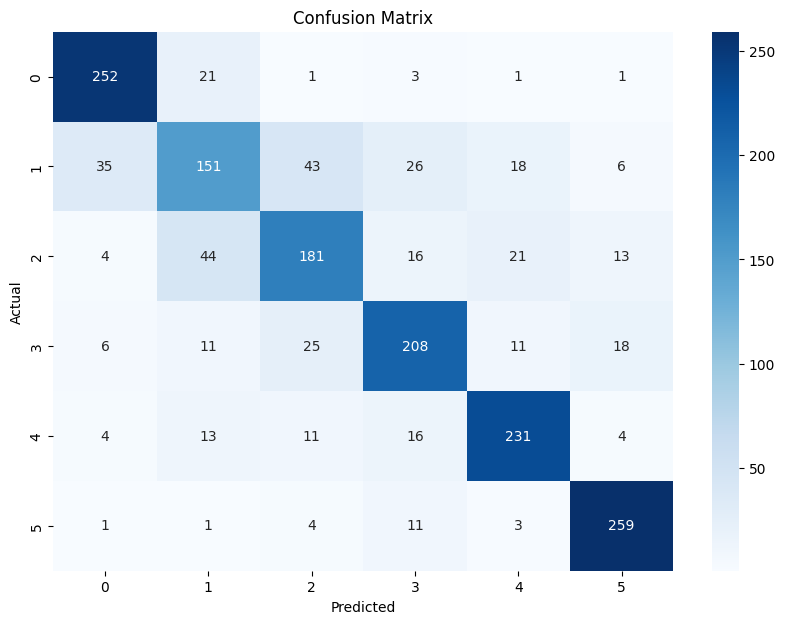

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       279
           1       0.63      0.54      0.58       279
           2       0.68      0.65      0.67       279
           3       0.74      0.75      0.74       279
           4       0.81      0.83      0.82       279
           5       0.86      0.93      0.89       279

    accuracy                           0.77      1674
   macro avg       0.76      0.77      0.76      1674
weighted avg       0.76      0.77      0.76      1674

Rata-rata akurasi pada 5-fold cross-validation: 0.7658343015461615
Standar Deviasi akurasi pada 5-fold cross-validation: 0.014387267320724874


In [81]:
# Mendefinisikan hyperparameter model
hyperparameters = {
    'max_depth': 16,
    'min_child_weight': 1,
    'learning_rate': 0.1,
    'n_estimators': 270,
    'subsample': 0.99,
    'colsample_bytree': 0.61,
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Mendefinisikan model XGBoost dengan hyperparameter
model = xgb.XGBClassifier(**hyperparameters, use_label_encoder=False)

accuracies = []
all_y_test = []
all_y_pred = []

# Loop melalui setiap fold
for train_index, test_index in kf.split(X_sm, y_sm):
    # Split data
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Melatih model
    model.fit(X_train, y_train)
    
    # Melakukan prediksi pada data pengujian
    y_pred = model.predict(X_test)
    
    # Menghitung akurasi pada data pengujian
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Akurasi pada fold: {accuracy}")

    # Menyimpan hasil prediksi dan data uji
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Menghitung confusion matrix dari semua prediksi
conf_matrix = confusion_matrix(all_y_test, all_y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
report = classification_report(all_y_test, all_y_pred)
print(report)

# Rata-rata dan Standar Deviasi
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Rata-rata akurasi pada 5-fold cross-validation: {mean_accuracy}")
print(f"Standar Deviasi akurasi pada 5-fold cross-validation: {std_accuracy}")

## Visualisasi Pencarian Hyperparameter

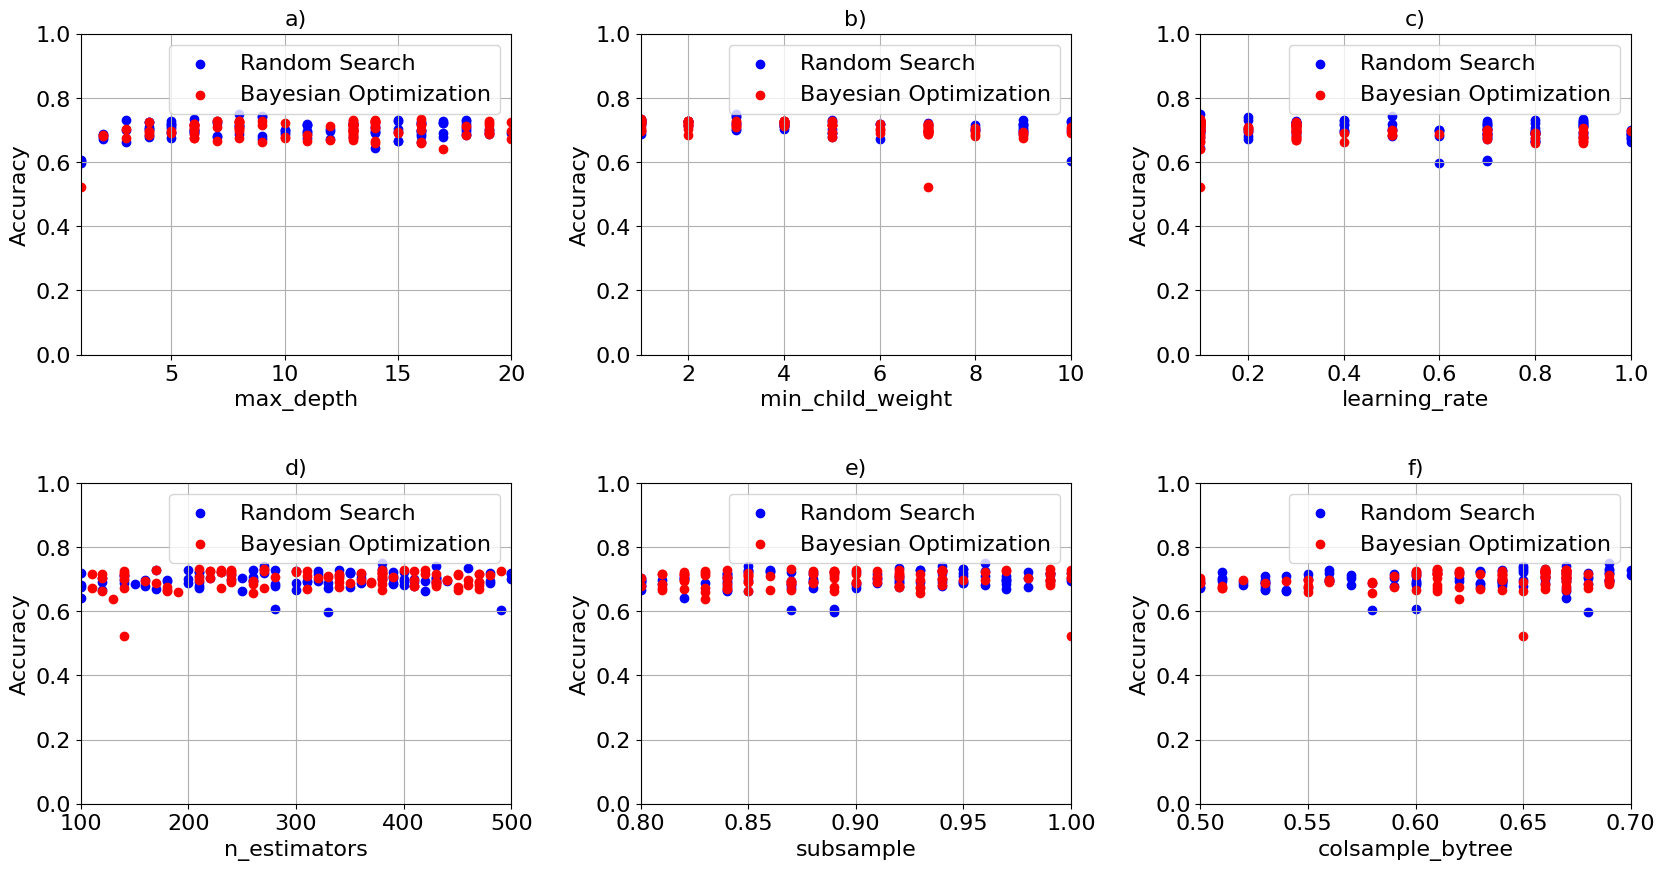

In [79]:
# Dapatkan data dari cv_results_ untuk masing-masing metode pencarian
params = ['max_depth', 'min_child_weight', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']
random_results = random_search.cv_results_
bayes_results = bayes_search.cv_results_

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10)) 
axes = axes.flatten() 

# Mendefinisikan warna untuk setiap metode pencarian
colors = {'Random Search': 'blue', 'Bayesian Search': 'red'}

# List huruf untuk judul grafik
titles = ['a', 'b', 'c', 'd', 'e', 'f']


# Batas atas dan bawah untuk setiap hyperparameter
x_limits = {
    'max_depth': (1, 20),
    'min_child_weight': (1, 10),
    'learning_rate': (0.1, 1),
    'n_estimators': (100, 500),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.5, 0.7)
}

for i, param in enumerate(params):

    # Random Search
    random_param_values = random_results[f'param_{param}']
    random_scores = random_results['mean_test_score']
    axes[i].scatter(random_param_values, random_scores, color=colors['Random Search'], label='Random Search')

    # Bayesian Search
    bayes_param_values = bayes_results[f'param_{param}']
    bayes_scores = bayes_results['mean_test_score']
    axes[i].scatter(bayes_param_values, bayes_scores, color=colors['Bayesian Search'], label='Bayesian Optimization')

    # Setting title, labels, and legend
    axes[i].set_xlabel(param, fontsize=16)
    axes[i].set_ylabel('Accuracy', fontsize=16)
    axes[i].legend(fontsize=16)

    # Set ukuran font angka pada sumbu x dan y
    axes[i].tick_params(axis='x', labelsize=16)
    axes[i].tick_params(axis='y', labelsize=16)

    # Set batas atas dan bawah pada sumbu x
    axes[i].set_xlim(x_limits[param])
    axes[i].set_ylim(0, 1)

    # Menambahkan judul
    axes[i].set_title(f'{titles[i]})', fontsize=16)
    
    # Menambahkan grid
    axes[i].grid(True)
    
# plt.tight_layout() 
 # Adjust layout to prevent overlap
plt.subplots_adjust(hspace=0.4, wspace=0.3)  

plt.show()
